# Identificando Entidades Nomeadas e Similaridade Semântica
Neste capítulo vamos treinar um *identificador de entidades  nomeadas* (NER - Named Entity Recognizer) usando a biblioteca [Spacy](https://spacy.io). A partir deste capítulo vamos importar também funções que já criamos anteriormente, e que encontram-se reproduzidas no módulo  [dhbbmining.py](https://github.com/fccoelho/text-mining-cientistas-sociais/blob/master/dhbbmining.py).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os, glob, pickle
import spacy
from IPython.core.display import display, HTML, Markdown
from spacy import displacy
from sqlalchemy import create_engine
from dhbbmining import *
import ipywidgets as widgets

Para utilizar o spacy em um corpus na lingua portuguesa, vamos primeiro importar o modelo liguístico do português: Descomente a linha abaixo se for a primeira vez que estiver rodando este notebook, e ainda não tiver baixado o corpus `pt_core_news_sm`.

In [ ]:
#!python3 -m spacy download pt_core_news_sm

In [6]:
nlp = spacy.load("pt_core_news_sm")

Em seguida podemos carregar os verbetes biográficos que salvamos no nosso banco SQLite.

In [7]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
biograficos = pd.read_sql_query('select * from resultados', con=eng)
biograficos.head()

,index,arquivo,title,natureza,sexo,cargos,corpo
0,0,4736.text,"RUBIM, Floriano",biográfico,m,\n - militar\n - dep. fed. ES 1955-1959\n - d...,\n\n«Floriano Lopes Rubim» nasceu em Alegre (E...
1,1,1376.text,"COELHO, Inocêncio Mártires",biográfico,m,\n - proc. ger. Rep. 1981-1985\nautor: \n - L...,\n\n«Inocêncio Mártires Coelho» nasceu em Belé...
2,2,732.text,"BOPP, Raul",biográfico,m,\n - diplomata\n - emb. Bras. Peru 1962-1963\n,\n\n«Raul Bopp» nasceu em Santa Maria (RS) no ...
3,3,2669.text,"KRÜGER, Nivaldo",biográfico,m,\n - dep. fed. PR 1979-1983\n - sen. PR 2002-...,\n\n«Nivaldo Passos Krüger» nasceu em Canoinha...
4,4,6310.text,POLÍTICA DE CLIENTELA,temático,None,NA,\n\nExpressão cunhada e conceito desenvolvido ...


Apesar de nomearmos nosso DataFrame "Biográficos", existe uma outra natureza de verbete neste corpus, os verbetes temáticos. Vejamos um exemplo:

In [8]:
print(biograficos[biograficos.natureza=='temático'].iloc[2].corpo[:1500])


 
Reunião realizada no Rio de Janeiro em agosto de 1934 sob a direção do
Partido Comunista Brasileiro (PCB).

Sua finalidade era condenar a política fascista em ascensão. Contou,
entre outras, com a presença de representantes operários.


Para começar a utilizar o Spacy, precisamos primeiro precisamos processar o texto. Nesta passagem várias análises linguísticas são realizadas.

In [9]:
doc = nlp(biograficos.corpo[0].strip())
type(doc)

spacy.tokens.doc.Doc

Vejamos os descritores disponíveis para cada token.

In [10]:
for i, token in enumerate(doc):
    print(f"Texto:{token.text},\n Lemma: {token.lemma_},\nPart of speech: {token.pos_},\nTag: {token.tag_}, \nDep:{token.dep_},\
            Shape:{token.shape_}, \nAlpha? {token.is_alpha}, \nStopword:{token.is_stop}\n")
    if i>2:
        break
    

Texto:«,
 Lemma: «,
Part of speech: PUNCT,
Tag: PUNCT, 
Dep:punct,            Shape:«, 
Alpha? False, 
Stopword:False

Texto:Floriano,
 Lemma: Floriano,
Part of speech: PROPN,
Tag: PROPN, 
Dep:nsubj,            Shape:Xxxxx, 
Alpha? True, 
Stopword:False

Texto:Lopes,
 Lemma: Lopes,
Part of speech: PROPN,
Tag: PROPN, 
Dep:flat:name,            Shape:Xxxxx, 
Alpha? True, 
Stopword:False

Texto:Rubim,
 Lemma: Rubim,
Part of speech: PROPN,
Tag: PROPN, 
Dep:flat:name,            Shape:Xxxxx, 
Alpha? True, 
Stopword:False


## Testando o NER do Spacy
Como o Spacy já inclui algum suporte à lingua portuguesa, antes de pensar em treinar nosso próprio NER, podemos avaliar a performance do existente. 

Abaixo vamos construir uma visualização interativa da marcação de entidades nos verbetes do DHBB.

In [11]:
from IPython.display import display,clear_output, HTML
from ipywidgets import interact

In [12]:
@interact(e=(0, len(biograficos)))
def mostra_ner(e=0):
    text = biograficos.iloc[e].corpo.strip()
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)
    clear_output(wait=True)

interactive(children=(IntSlider(value=0, description='e', max=7838), Output()), _dom_classes=('widget-interact…

Além da visualização, podemos extrair as entidades presentes em um verbete:

In [13]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Floriano Lopes Rubim 1 21 PER
Alegre 33 39 LOC
ES 41 43 LOC
Francisco Lopes Rubim 84 105 PER
Maria
Sílvia Lousada Rubim 133 159 PER
Bacharel 162 170 LOC
Faculdade de Direito da
Universidade do Espírito Santo 208 262 LOC
Escola de Educação
Física 284 309 LOC
Rio de Janeiro 313 327 LOC
Distrito Federal 335 351 LOC
Força Policial do Espírito Santo 391 423 ORG
Itália 491 497 LOC
Segunda
Guerra Mundial 508 530 MISC
Brasil 558 564 LOC
Penitenciária do Estado do Espírito Santo 628 669 LOC
Casa Militar 741 753 LOC
Espírito Santo 771 785 LOC
Carlos Lindenberg 787 804 PER
Espírito Santo 899 913 LOC
Partido Trabalhista
Brasileiro 929 959 ORG
PTB 961 964 MISC
Força
Policial 1008 1022 MISC
Legislativo 1080 1091 ORG
Educação e Cultura 1157 1175 LOC
Justiça da Assembléia 1181 1202 MISC
Coligação Democrática 1297 1318 ORG
PTB 1332 1335 ORG
Republicano 1353 1364 PER
PR 1366 1368 LOC
Representação Popular 1374 1395 ORG
PRP 1397 1400 ORG
Social Progressista 1404 1423 MISC
PSP 1425 1428 ORG
Câmara Federal

O NER incluído no Spacy não é muito preciso, como podemos ver. Mas podemos treinar uma versão melhorada seguin as [instruções da documentação do Spacy](https://spacy.io/usage/training#basics)

Podemos ainda ver que tipos de entidades o Spacy reconhece:

In [14]:
set([ent.label_ for ent in doc.ents])

{'LOC', 'MISC', 'ORG', 'PER'}

# Similaridade Semântica
Outra análise interessante que pode ser feita sobre os verbetes do DHBB é a de similaridade semântica. Este tipo de análise se baseia em modelos vetoriais tipo "word2vec", que representam palavras de um corpus em um espaço semântico.
Podemos aplicar o modelo pré-treinado do Spacy como exemplo, mas idealmente deve-se treinar estes modelos em corpora similares ao que se deseja analizar ou no próprio, como faremos no capítulo 5 deste livro.

In [21]:
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

Construir uma rede de verbetes similares usando a uma comparação de pares de documentos é uma abordagem muito ineficiente, por isso no exemplo abaixo vamos nos restringir a 20 comparações.

In [22]:
G = nx.Graph()

for i,verb1 in tqdm(enumerate(biograficos.itertuples())):
    for j,verb2 in enumerate(biograficos.itertuples()):
        if j>=i:
            continue
        doc1 = nlp(verb1.corpo)
        doc2 = nlp(verb2.corpo)
        sim = doc1.similarity(doc2)
        # print(sim)
        if sim > 0.8:
            G.add_edge(verb1.title, verb2.title, weight=sim)
    if len(G.nodes)>20:
        break
            

20it [00:55,  2.76s/it]


O grafo resultante, é formado por 21 nós representando cada verbete e arestas representando a similaridade entre cada par.

In [23]:
G.order()

21

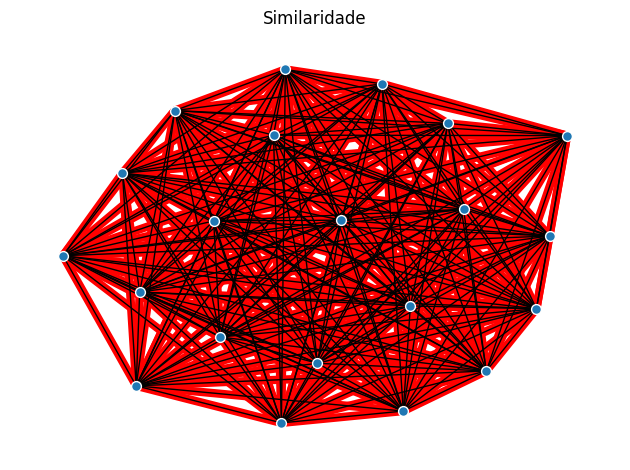

In [24]:
connected = [n for n, d in G.degree() if d > 0]
fig, ax = plt.subplots()
# Identifica verbetes conectados
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
#### desenha grafo ####
pos = nx.nx_agraph.graphviz_layout(G)
ax.set_title(f"Similaridade")
# desenha aresta
options = {"ax": ax, "edge_color": "red"}
nx.draw_networkx_edges(G0, pos, width=6, **options);
# desenha nós
options = {"ax": ax, "node_size": 50, "edgecolors": "white"}
nx.draw(G, pos, nodelist=connected, **options)
fig.tight_layout()

Podemos agora exportar este grafo para o formato GEXF e visualizá-lo no [Gephi](https://gephi.org/), por exemplo, se quisermos construir uma visualização mais elaborada.

In [25]:
nx.write_gexf(G0,'dhbb.gexf')